# Clustering de Pozos de Petroleo con OPTICS

La Argentina tiene 5 cuancas productivas. La intecion es aplicar un algortimo de clustering para agrupar los pozos en dichas cuencas a partir de su latitud y longitud. OPTICS es un metodo que tiene la ventaja de tener pocos parametros a determinar, no es necesario indicar el numero de clusters y tiene una mayor felxibilidad que DBSCAN ya que este ultimo puede no funciona bien si los clusters tienen distinta densidad de puntos (lo que ocurre en este caso ya que hay cuencas con mayor cantidad de perforaciones que otras).

In [2]:
#Importamos las dependencias necesarias.

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

In [5]:
#dataset generado con descarga automatica de la secretaria de energia ---> https://github.com/fzambrun/download_automation_selenium/blob/main/Descarga_Automatica_Selenium.ipynb

data=pd.read_csv(r'C:\Users\franc\Desktop\Digital House\CAPIV\Notebooks/Dic_2021_CAPIV.csv')

In [6]:
#Vemos el dataset

data.sample(10)

,Periodo,Empresa,Cuenca,Provincia,Área,Yacimiento,ID Pozo,Sigla,Form.Prod.,Cód.Propio,...,Tipo Pozo,Clasificación,Sub clasificación,Tipo de Recurso,Sub tipo de Recurso,Observaciones,Latitud,Longitud,Cota,Profundidad
33158,Diciembre de 2021,"SINOPEC ARGENTINA EXPLORATION AND PRODUCTION, ...",GOLFO SAN JORGE,Santa Cruz,LAS HERAS,LAS HERAS,68182.0,YPF.SC.ER-17,CAST,VOA,...,PET,NaN,NaN,NaN,NaN,NaN,-46.737140,-68.857160,287.00,1075.0
43597,Diciembre de 2021,YPF S.A.,CUYANA,Mendoza,LA VENTANA,GRAN BAJADA BLANCA,124534.0,AS.Md.GBB-8,BARR,AR0200003169,...,PET,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-33.438841,-68.621639,1056.42,2478.0
16757,Diciembre de 2021,PAN AMERICAN ENERGY SL,GOLFO SAN JORGE,Chubut,ANTICLINAL GRANDE - CERRO DRAGON,VALLE HERMOSO,157073.0,PAE.Ch.VH-883,MELC,PVH-883,...,PET,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-45.746930,-68.572750,356.97,2215.0
63248,Diciembre de 2021,YPF S.A.,GOLFO SAN JORGE,Santa Cruz,LOS PERALES - LAS MESETAS,LOS PERALES,100421.0,YPF.SC.LP-267,BBAR,406020402670,...,IA,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-46.234057,-69.199652,466.00,1589.0
11526,Diciembre de 2021,OILSTONE ENERGIA S.A.,NEUQUINA,Neuquén,AL SUR DE LA DORSAL,LOMA PEDREGOSA,50871.0,PNR.NQ.LPd.a-1010,LOTE,1140401051010,...,OT,EXPLOTACION,AVANZADA,CONVENCIONAL,NaN,NaN,-39.189273,-69.118695,670.50,1600.0
23187,Diciembre de 2021,PLUSPETROL S.A.,NEUQUINA,La Pampa,CNQ 7/A,EL CORCOBO NORTE,157370.0,PLU.LP.ECN-3106,CENT,NaN,...,PET,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-37.497695,-68.225549,623.17,680.3
70851,Diciembre de 2021,YPF S.A.,NEUQUINA,Neuquén,CHIHUIDO DE LA SIERRA NEGRA,CHIHUIDO DE LA SIERRA NEGRA,112076.0,YPF.Nq.ChSN-31,AGRI,301545600310,...,IA,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-37.315125,-69.302707,967.25,1375.0
73126,Diciembre de 2021,YPF S.A.,NEUQUINA,Neuquén,DADIN,HUINCUL,51655.0,SOA.NQ.Sol-31,LOTE,1140000420031,...,OT,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-38.900590,-69.226565,613.70,755.0
21512,Diciembre de 2021,PETROQUIMICA COMODORO RIVADAVIA S.A.,NEUQUINA,La Pampa,25 DE MAYO - MEDANITO SUD ESTE LP,25 DE MAYO - MEDANITO SUDESTE LP,75547.0,PC.LP.EM-1316b,QTUC,EM-1316b,...,PET,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-38.052300,-67.837937,293.00,1539.0
37783,Diciembre de 2021,TECPETROL S.A.,GOLFO SAN JORGE,Chubut,EL TORDILLO,EL TORDILLO,156375.0,TPT.Ch.S-2714,MELC,S-2714,...,IA,EXPLOTACION,DESARROLLO,CONVENCIONAL,NaN,NaN,-45.892411,-67.884463,447.00,3299.0


In [7]:
#Vemos la cantidad de valores nulos y los campos del dataset

data.isna().sum()

Periodo                    0
Empresa                    0
Cuenca                     5
Provincia                  8
Área                       8
Yacimiento                 8
ID Pozo                    8
Sigla                      8
Form.Prod.              2688
Cód.Propio              7864
Nom.Propio              4470
Prod.Men.Pet.(m3)          8
Prod.Men.Gas(Mm3)          8
Prod.Men.Agua(m3)          8
Prod.Acum.Pet.(m3)         8
Prod.Acum.Gas(Mm3)         8
Prod.Acum.Agua(m3)         8
Iny.Agua(m3)               8
Iny.Gas(Mm3)               8
Iny.CO2(Mm3)               8
Iny.Otros(m3)              8
RGP                        8
% de Agua                  8
TEF                        8
Vida Útil                  8
Sist.Extrac.               9
Est.Pozo                   9
Tipo Pozo                  9
Clasificación          17729
Sub clasificación      17729
Tipo de Recurso        21194
Sub tipo de Recurso    77473
Observaciones          75369
Latitud                    8
Longitud      

In [8]:
#Eliminamos los valores que faltan de Lat y Long

data.dropna(subset=['Latitud', 'Longitud'], inplace=True)

Transformar las coordeneas numericas en la froma geometrica **Punto**

In [10]:
geo_pozos = gpd.GeoDataFrame(data
                     , geometry=gpd.points_from_xy(data.Longitud, data.Latitud))

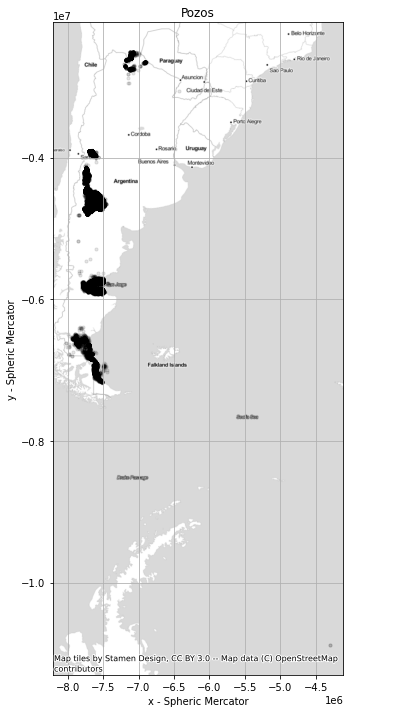

In [11]:
# Mostramos los pozos en un mapa con medidas segun escala Spheric Mercator
fig, ax = plt.subplots(figsize=(8,12))
ax.set_title('Pozos')
ax.set_xlabel('x - Spheric Mercator')
ax.set_ylabel('y - Spheric Mercator')
plt.grid()

geo_pozos.crs = "EPSG:4326"                        #1 Informamos sistema de coordenadas
geo_pozos_3857 = geo_pozos.to_crs(epsg=3857)       #2 Cambia el sistema para usar contextly
geo_pozos_3857.plot(ax=ax,
                   legend = True,
                   alpha=0.1,
                   markersize=10,
                   color='black')

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

In [12]:
#Filtro todo lo que tenga longitud mas grande que -60

mask_long = geo_pozos['Longitud']<-60
data_pozos = geo_pozos[mask_long]
data_pozos.shape

(80497, 38)

In [13]:
# Creamos el dataset con las variables predictoras

X = data_pozos[['Longitud','Latitud']]

Y = data_pozos['Cuenca']

# Escalamos los datos

scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

## Clustering con OPTICS

In [14]:
# Importamos OPTICS de Sckit-Learn
from sklearn.cluster import OPTICS

In [15]:
#Insatnciamos el modelo

clustering_model = OPTICS(min_samples=500, xi=0.2)

En cuanto a los parametros para el modelo vamos se indica en principio que una cuenca debe tener un minimo de 500 pozos (parece un valor logico consideranod que hay mas de 80000 registros en el dataset) y para felxibilizar como se consituye uun limite para un cluster se setea el parametro "xi" en 0.2 en lugar de su valor por defalut de 0.05. El resto seran los valores por default.

Para profundizar sobre este parametro y otros de este metodo: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.OPTICS.html#sklearn.cluster.OPTICS

In [16]:
# Hacemos un fit sobre el modelo
y_pred = clustering_model.fit_predict(X)

In [17]:
unique, counts = np.unique(y_pred, return_counts=True)
print(np.asarray((unique, counts)).T)

[[   -1     2]
 [    0  3674]
 [    1 30503]
 [    2 42312]
 [    3  3007]
 [    4   999]]


### Vemos la solucion en un mapa

In [18]:
labels = set(y_pred)
labels

{-1, 0, 1, 2, 3, 4}

los lables -1 son outliers significan que no pertenecen a ningun cluster

In [19]:
#Agrego la prediccion al dataframe
data_pozos = data_pozos.assign(y_pred = y_pred)

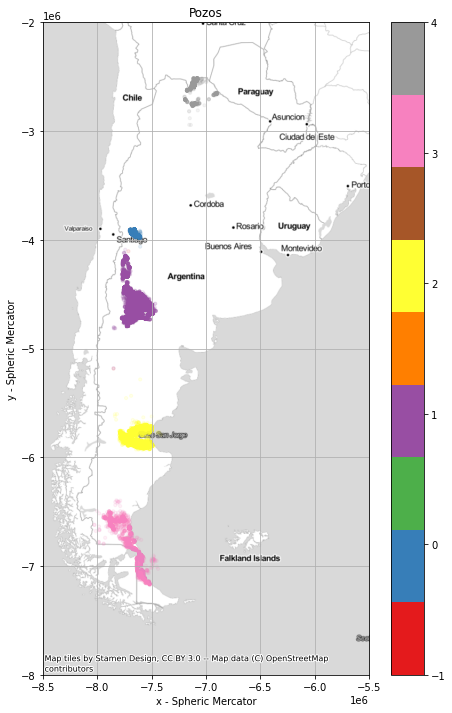

In [20]:
# Mostramos los pozos en un mapa con medidas segun escala Spheric Mercator
fig, ax = plt.subplots(figsize=(8,12))
ax.set_title('Pozos')
ax.set_xlabel('x - Spheric Mercator')
ax.set_xlim(-8.5*1000000, -5.5*1000000)
ax.set_ylabel('y - Spheric Mercator')
ax.set_ylim(-0.8*10000000, -0.2*10000000)
plt.grid()

data_pozos.crs = "EPSG:4326"                        #1 Informamos sistema de coordenadas
df_3857 = data_pozos.to_crs(epsg=3857)       #2 Cambia el sistema para usar contextly
df_3857.plot(ax=ax,
                   legend = True,
                   alpha=0.1,
                   markersize=10,
                   cmap = 'Set1',
                  column = 'y_pred')

ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite)

In [21]:
label_cuencas = {'GOLFO SAN JORGE' : 2 , 'NEUQUINA' : 1 , 'CUYANA' : 0 , 'AUSTRAL': 3 , 'NOROESTE' : 4}

data_pozos['label_cuencas'] = data_pozos['Cuenca'].map(label_cuencas)

In [22]:
data_pozos['Cuenca'].value_counts()

GOLFO SAN JORGE    42310
NEUQUINA           30505
CUYANA              3673
AUSTRAL             3007
NOROESTE             988
NORESTE               11
ÑIRIHUAU               2
CAÑADON ASFALTO        1
Name: Cuenca, dtype: int64

In [23]:
(data_pozos['label_cuencas'] == data_pozos['y_pred']).value_counts()

True     80480
False       17
dtype: int64

Son 17 pozos de un total de 80504 los que clasifico mal (un 0.02%) y 14 son de cuencas no desarrolladas (NORESTE, ÑIRIHUAU y CAÑADON ASFALTO)

In [24]:
data_pozos[(data_pozos['label_cuencas'] != data_pozos['y_pred'])]

,Periodo,Empresa,Cuenca,Provincia,Área,Yacimiento,ID Pozo,Sigla,Form.Prod.,Cód.Propio,...,Tipo de Recurso,Sub tipo de Recurso,Observaciones,Latitud,Longitud,Cota,Profundidad,geometry,y_pred,label_cuencas
10634,Diciembre de 2021,GRECOIL y CIA. S.R.L.,NEUQUINA,Mendoza,MINA CERRO DEL ALQUITRAN,MINA CERRO DEL ALQUITRAN,135911.0,CA-101,GNEU,CA-101,...,NaN,NaN,Cargado automáticamente como [Sin movimientos],-34.561671,-69.292904,1769.00,1400.0,POINT (-69.29290 -34.56167),-1,1.0
10636,Diciembre de 2021,GRECOIL y CIA. S.R.L.,NEUQUINA,Mendoza,MINA CERRO DEL ALQUITRAN,MINA CERRO DEL ALQUITRAN,130917.0,CA-12,PIRC,NaN,...,NaN,NaN,Cargado automáticamente como [Sin movimientos],-43.929140,-69.490690,1725.05,400.0,POINT (-69.49069 -43.92914),2,1.0
10976,Diciembre de 2021,KILWER S.A.,ÑIRIHUAU,Chubut,CÑ-01 ÑIRIHUAU SUR,ÑIRIHUAU,145768.0,SH.CH.HO.x-1,FIMP,NaN,...,CONVENCIONAL,NaN,Cargado automáticamente como [Sin movimientos],-42.153350,-70.525302,984.00,2302.0,POINT (-70.52530 -42.15335),-1,NaN
10977,Diciembre de 2021,KILWER S.A.,ÑIRIHUAU,Chubut,CÑ-01 ÑIRIHUAU SUR,ÑIRIHUAU,145769.0,SH.CH.PCH.x-1,FIMP,NaN,...,CONVENCIONAL,NaN,Cargado automáticamente como [Sin movimientos],-42.123810,-70.524372,931.00,2500.0,POINT (-70.52437 -42.12381),1,NaN
28419,Diciembre de 2021,ROCH S.A.,NEUQUINA,Mendoza,AGUA BOTADA,AGUA BOTADA,161276.0,ROC.Md.AB.x-1001,VMUT,NEU00932,...,CONVENCIONAL,NaN,Cargado automáticamente como [Sin movimientos],-34.246111,-68.323611,2023.80,2303.0,POINT (-68.32361 -34.24611),0,1.0
35850,Diciembre de 2021,SELVA MARIA OIL S.A.,NORESTE,Jujuy,LA BREA (CNO-9),EL OCULTO,79223.0,YPF.Jj.EO.x-1,YACO,Jj EO.x-1,...,NaN,NaN,NaN,-23.740400,-64.489000,425.78,4031.0,POINT (-64.48900 -23.74040),4,NaN
35851,Diciembre de 2021,SELVA MARIA OIL S.A.,NORESTE,Jujuy,LA BREA (CNO-9),EL OCULTO,79225.0,YPF.Jj.EO.x-1001,YACO,EO.x-1001,...,NaN,NaN,NaN,-23.804600,-64.461700,539.00,2569.0,POINT (-64.46170 -23.80460),4,NaN
35852,Diciembre de 2021,SELVA MARIA OIL S.A.,NORESTE,Jujuy,LA BREA (CNO-9),EL OCULTO,79224.0,YPF.Jj.EO.x-2,YACO,EO.x-2,...,NaN,NaN,NaN,-23.754900,-64.467400,473.13,3436.0,POINT (-64.46740 -23.75490),4,NaN
35853,Diciembre de 2021,SELVA MARIA OIL S.A.,NORESTE,Jujuy,LA BREA (CNO-9),LA BREA ESTE,79226.0,YPF.Jj.JB.x-1,YACO,JB1,...,NaN,NaN,NaN,-23.827900,-64.414000,442.35,1646.0,POINT (-64.41400 -23.82790),4,NaN
35854,Diciembre de 2021,SELVA MARIA OIL S.A.,NORESTE,Jujuy,LA BREA (CNO-9),LA BREA ESTE,79227.0,YPF.Jj.JB.x-3,YACO,JB 3,...,NaN,NaN,NaN,-23.821500,-64.422300,440.94,1582.0,POINT (-64.42230 -23.82150),4,NaN
